# Softmax回归的从0开始实现
所有的实现Softmax的细节<br>
巨无敌难，看的一知半解


----

## 导包

In [2]:
import torch
from IPython import display
from d2l import torch as d2l

batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ../data\FashionMNIST\raw\train-images-idx3-ubyte.gz to ../data\FashionMNIST\raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ../data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to ../data\FashionMNIST\raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ../data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ../data\FashionMNIST\raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ../data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ../data\FashionMNIST\raw



In [5]:
#28*28,把一张图片展成向量。因为fashion-mnist数据集中图片大小是28 *28
num_inputs = 784
#因为Fashion_MNIST数据集有10个类别，也就是10个输出
num_outputs = 10 

W = torch.normal(0, 0.01, (num_inputs, num_outputs), requires_grad=True)
b = torch.zeros(num_outputs, requires_grad=True)

# 实现Softmax
![title](./picture/Softmax函数.png)

In [7]:
#X是一个矩阵 batch_size行，784列
def softmax(X):
    X_exp = torch.exp(X)
    partition = X_exp.sum(1, keepdim=True)#拍墙上 0行1列
    return X_exp / partition #这里应用了广播机制

## 定义Softmax回归模型

In [23]:
def net(X):
    return softmax(torch.matmul(X.reshape(-1, W.shape[0]), W) + b)

## 定义损失函数

In [10]:
# 这里理解一下索引
# y = torch.tensor([0, 2])
# y_hat = torch.tensor([[0.1, 0.3, 0.6],[0.3, 0.2, 0.5]])
# y_hat[[0, 1], y]
#【这里是按照计算机里的编号】（0,1,2）
#第0行（第0个样本）取第0个元素（第0个预测值），第一行取第2个元素

tensor([0.1000, 0.5000])

### 实现交叉熵损失函数

In [11]:
def cross_entropy(y_hat, y):
    return -torch.log(y_hat[range(len(y_hat)), y])

cross_entropy(y_hat, y)

tensor([2.3026, 0.6931])

## 计算分类精度
将预测类别和真实y元素进行比较<br>
首先，如果y_hat是矩阵，那么假定第二个维度存储每个类的预测分数。 我们使用`argmax获得每行中最大元素的索引来获得预测类别。` 然后我们将预测类别与真实y元素进行比较。 由于等式运算符“==”对数据类型很敏感， 因此我们将y_hat的数据类型转换为与y的数据类型一致。 结果是一个包含0（错）和1（对）的张量。 最后，我们求和会得到正确预测的数量。


In [20]:
def accuracy(y_hat, y):
    """计算预测正确的数量"""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

In [1]:
#accuracy(y_hat, y) / len(y)

'''这里为什么不在accuracy里面除以len(y),
是因为会存在最后一个batch_size不读不满的情况
而在里面除的话计算是不正确的'''

In [13]:
def evaluate_accuracy(net, data_iter):  #@save
    """计算在指定数据集上模型的精度"""
    if isinstance(net, torch.nn.Module):
        net.eval()  # 将模型设置为评估模式，可以不去做梯度相关的东西，性能会稍微有一点提升
    metric = Accumulator(2)  # 正确预测数、预测总数
    with torch.no_grad():
        for X, y in data_iter:
            metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1] #分类正确样本数 / 总样本数

In [14]:
class Accumulator:  #@save
    """在n个变量上累加"""
    def __init__(self, n):
        self.data = [0.0] * n #生成n个列表元素

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [24]:
evaluate_accuracy(net, test_iter)

0.0926

## Softmax回归的训练（一次）
同时实现了如果是自定义的模型，或者是torch.nn.Module生成的网络。之后可以实现代码的重用


In [31]:
def train_epoch_ch3(net, train_iter, loss, updater):
    if isinstance(net, torch.nn.Module):
        net.train() #开始训练，开始计算梯度
    metric = Accumulator(3)#使用长度为3的迭代器来累加我们需要的信息
    for X, y in train_iter:#扫一遍数据
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()#梯度清0
            l.backward()#反向传播，计算梯度
            updater.step()#参数进行自更新
            metric.add(
                float(l) * len(y), accuracy(y_hat, y),
                y.size().numel())
        else:#自己实现的
            l.mean().backward()#l是一个向量，需要sum后计算梯度
            updater(X.shape[0])#根据批量大小更新一下
            metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
    return metric[0] / metric[2], metric[1] / metric[2]
#metric[0]:所有loss的累加
#metric[1]:分类正确的样本数
#metric[2]:样本数


## 定义一个在动画中绘制数据的实用程序类

In [27]:
class Animator:  #@save
    """在动画中绘制数据"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # 增量地绘制多条线
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # 使用lambda函数捕获参数
        self.config_axes = lambda: d2l.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

## 训练函数

In [28]:
def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):
    #一个可视化的动画
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                       legend=['train loss','tiain acc', 'test acc'])
    #扫数据
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter) #在测试数据集评价精度
        animator.add(epoch + 1,train_metrics +(test_acc,))
    train_loss, train_acc = train_metrics
    assert train_loss < 0.5,train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc

## 小批量随机梯度下降来优化模型的损失函数

In [29]:
lr = 0.1

def updater(batch_size):
    return d2l.sgd([W, b], lr, batch_size)

## 训练模型10个迭代周期

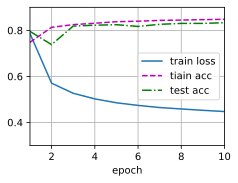

In [32]:
num_epochs = 10
train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, updater)

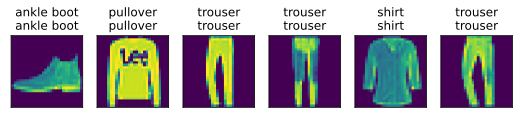

In [35]:
def predict_ch3(net, test_iter, n=6):
    """预测标签"""
    for X, y in test_iter:
        break
    trues = d2l.get_fashion_mnist_labels(y)
    preds = d2l.get_fashion_mnist_labels(net(X).argmax(axis=1))
    titles = [true + '\n' + pred for true, pred in zip(trues, preds)]
    d2l.show_images(X[0:n].reshape((n, 28, 28)), 1, n, titles = titles[0:n])

predict_ch3(net, test_iter)